In [15]:
import encoding_tools
from pathlib import Path
import numpy as np
import pickle
import pandas as pd
from sklearn import preprocessing

# ML imports
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance
from scipy import optimize, linalg
import scipy
from sklearn.model_selection import KFold # import KFold
import matplotlib.pyplot as plt

# custom imports
import encoding_tools as encoding
import chimera_tools as chimera
import GP_tools as GP

In [2]:
Processed_Folder = Path(r"Phosphotase_Encode.ipynb").parent.absolute() / Path("Processed Data")

dicts = ['EFI_ID_List', 'metabolite_dict', 'Protein_seq_dict']

with open(Processed_Folder / Path('EFI_ID_List.p'), 'rb') as EFI_ID:
    EFI_ID_List = pickle.load(EFI_ID)

with open(Processed_Folder / Path('metabolite_dict.p'), 'rb') as metabolite:
    metabolite_dict = pickle.load(metabolite)

with open(Processed_Folder / Path('Protein_seq_dict.p'), 'rb') as Protein_seq:
    Protein_seq_dict = pickle.load(Protein_seq)

activations = pd.read_csv(Processed_Folder / Path('activations.csv'), index_col=0)

In [3]:
# Need to pad protein sequences to the max length of the longest one
max_len = len(max(Protein_seq_dict.values(), key=len))
fillchar = '-' # This is whats used in the GP-UCB paper
Padded_dict = {}
OH_dict = {}
for ID in EFI_ID_List:
    Padded_dict[ID] = Protein_seq_dict[ID].upper().ljust(max_len, fillchar)
    OH_dict[ID] = encoding_tools.one_hot_seq(seq_input=Padded_dict[ID])

In [40]:
# Preparing input training data X to feed into ML Model
input_len = len(OH_dict[EFI_ID_List[0]])*21
num_inputs = len(OH_dict.keys())

X = np.zeros((num_inputs,input_len))
for i in range(0,len(EFI_ID_List)):
    ID = EFI_ID_List[i]
    X_seq = OH_dict[ID]
    X_seq = np.reshape(X_seq,(1,X_seq.shape[0]*21))
    X[i,:] = X_seq

# Preapre output training data y to feed into ML Model
y = activations.values[0,:]

'''
# Now we need to normalize the data
ss1 = preprocessing.StandardScaler()
y = y.reshape(-1,1) # Single feature dataset
y = ss1.fit_transform(y) # fit the SS1 and standardize x_train
y = ss1.transform(y) # transform x_test
'''

'\n# Now we need to normalize the data\nss1 = preprocessing.StandardScaler()\ny = y.reshape(-1,1) # Single feature dataset\ny = ss1.fit_transform(y) # fit the SS1 and standardize x_train\ny = ss1.transform(y) # transform x_test\n'

In [5]:
ID = np.random.randint(low=0,high=218)
len_comp = len(Padded_dict[EFI_ID_List[ID]])
len(Padded_dict[EFI_ID_List[0]]) == len(Padded_dict[EFI_ID_List[ID]])
print(len_comp)
print(ID) 

604
117


In [6]:
def ML_train(X, y):
    # test the optimization of the hyp-prams
    initial_guess = [0.9,0.9]

    # take the log of the initial guess for optimiziation 
    initial_guess_log = np.log(initial_guess)

    # optimize to fit model
    result = scipy.optimize.minimize(GP.neg_log_marg_likelihood, initial_guess_log, args=(X,y), method='L-BFGS-B')
    
    print('Full GP regression model')
    print('Hyperparameters: ' + str(np.exp(result.x[0])) + ' ' + str(np.exp(result.x[1])))

    # next set of hyper prams 
    final_prams = [np.exp(result.x[0]), np.exp(result.x[1])]
    
    return final_prams
    

In [7]:
def cross_validation(X, log_data, property_):
    path_outputs = 'outputs/'

    kf = KFold(n_splits=20) # Define the split
    kf.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

    mu_s = []
    var_s = []
    y_s = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]

        log_data_train, log_data_test = log_data[train_index], log_data[test_index]

        y_train = (log_data_train - np.mean(log_data_train))/np.std(log_data_train)
        y_test = (log_data_test - np.mean(log_data_train))/np.std(log_data_train)

        initial_guess = [0.1,10]

        # take the log of the initial guess for optimiziation 
        initial_guess_log = np.log(initial_guess)

        # optimize to fit model
        result = scipy.optimize.minimize(GP.neg_log_marg_likelihood, initial_guess_log, args=(X_train,y_train), method='L-BFGS-B')#,

        # next set of hyper prams 
        prams_me = [np.exp(result.x[0])**2, np.exp(result.x[1])]

        # next used trained GP model to predict on test data
        mu, var = GP.predict_GP(X_train, y_train, X_test, prams_me)
        
        # un normalize
        y_test_real = np.exp(y_test*np.std(log_data_train)  + np.mean(log_data_train))
        mu_real = np.exp(mu*np.std(log_data_train)  + np.mean(log_data_train))
        
        mu_s.append(mu)
        var_s.append(var)
        y_s.append(y_test)

    # reformat all
    y_s_all = [j for i in y_s for j in i]
    mu_s_all = [j for i in mu_s for j in i]

    # plot results
    plt.figure('My GP test set evaluation', figsize=(1.5, 1.5))
    plt.plot(y_s_all, mu_s_all, 'o', ms=3, color='k')


    # calculate correlation 
    measured = y_s_all
    predicted = mu_s_all

    par = np.polyfit(measured, predicted, 1, full=True)
    slope=par[0][0]
    intercept=par[0][1]

    # calc correlation 
    variance = np.var(predicted)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(measured, predicted)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    
    print('20-fold corss validation of GP regression model')
    print('R = %0.2f'% np.sqrt(Rsqr))

    max_x = np.max(y_s_all)
    min_x = np.min(y_s_all)
    
    plt.plot([min_x, max_x], [slope*min_x+intercept, slope*max_x+intercept], '-', color='k')
    plt.savefig(path_outputs + str(property_)+'_matern_kernel_CV_fig1.pdf', bbox_inches='tight', transparent=True)
    plt.show()
    return measured, predicted

In [33]:
# Prep y data for CV function
log_data = np.log(y)

In [41]:
# Perform ML model training
final_prams = ML_train(X, y)

Full GP regression model
Hyperparameters: 2.24125819484e-11 203.879134241


20-fold corss validation of GP regression model
R = 0.00


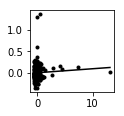

([-0.17646701924042829,
  -0.28071254015241298,
  -0.57259999870597067,
  -0.55696317056917299,
  -0.23901433178761905,
  -0.29634936828921077,
  0.33954830927389706,
  0.30306237695470234,
  -0.31719847247160776,
  -0.025311013918050244,
  -0.45792992570278734,
  0.018225957465326421,
  -0.018261210767966971,
  -0.28930874621528968,
  -0.34664572486760786,
  -0.51865666082456274,
  -0.51865666082456274,
  -0.57599363947688098,
  0.11726255695569433,
  -0.44046987175321967,
  -0.044323473791747947,
  -0.39877025091516993,
  -0.46165580328268829,
  -0.44602241211896732,
  -0.14377684962036025,
  0.52324784003173808,
  -0.36264432591245493,
  -0.57108954142873569,
  0.038612713956385339,
  -0.21673267505105859,
  -0.14898798000826721,
  -0.26884397893012857,
  0.080301757059641599,
  0.16576157593331209,
  0.20740440031292978,
  -0.073684664249490189,
  0.32712752040433107,
  -0.54737179156764282,
  -0.094506076439299189,
  -0.11012213558165596,
  0.40000246306866216,
  0.144940163743503

In [42]:
# Perform CV train
cross_validation(X=X, log_data=y, property_='activations')

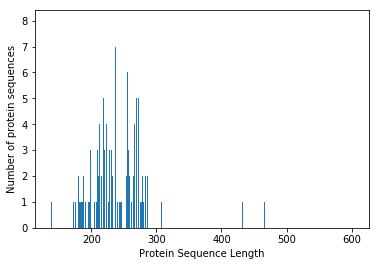

In [52]:
import matplotlib.pyplot as plt

p_length = [0]*218

for i in range(0,len(Protein_seq_dict.values())):
    p_length[i] = len(Protein_seq_dict[EFI_ID_List[i]])

plt.hist(p_length,bins=600)
plt.xlabel('Protein Sequence Length')
plt.ylabel('Number of protein sequences')
plt.show()
